# Computer Detection of Harmful Algal Bloooms

![algal bloom](download.jpeg)

## The problem 

Phytoplankton are single-celled algae that live in freshwater, saltwater, and everywhere in between. Algal blooms, big explosions of phytoplankton growth, happen naturally every late spring and early fall all around the globe. Sometimes, blooms grow out of control for a variety of reasons: excess of nutrient from land based runoff, influx of freshwater, higher than normal temperatures. These are called Harmful Algal Blooms (HABs). HABs pose a threat to human health and ecosystem health. 

![hab facts](download1.jpeg)

Early detection of algal blooms from imagery can help scientists and policy makers sample blooms as soon as possible to determine if they are toxic, and make important decisions regarding public health: beach closures, fisherman warnings, and seafood warnings can all help humans avoid harmful effects of HABS. My goal is to create a model that classifies algal blooms using imagery obtained from Google. Algal blooms come in all differnet shapes, sizes and colors, and this highly varied dataset will hopefully lead to a model that is able to classsify algal blooms in all forms. 

## Imports and Settings 

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import  PIL
from PIL import Image
import cv2
import time
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
%matplotlib inline

# custom function
from data_cleaning import *

## Image Preprocessing

The first step in my process was image preprocessing. This was an iterative process that I completed over several days. In summary the steps I took were as follows:

**Step 1: Splitting the data into folders**

This step was completed with a python script, split.py. I initially had the images split up into two folders: algae and not-algae. I created a new directory named split that contained an algae and not-algae folder and divided these images in 80/20/20 percentages across the train, test and validation folders, respectively.  

**Step 2: Resizing the images**

**Step 3: Rescaling the images**

**Step 4: Image Augmentation**

In [3]:
# get_img_stats is a function loaded in from data_cleaning.py
# it loops through each directory and gets the dimensions of each image and prints the minimum

test_algae = "split/test/algae/*"
test_not_algae = "split/test/not_algae/*"
get_img_stats(test_algae)
get_img_stats(test_not_algae)

train_algae = "split/train/algae/*"
train_not_algae = "split/train/not_algae/*"
get_img_stats(train_algae)
get_img_stats(train_not_algae)

val_algae = "split/validation/algae/*"
val_not_algae = "split/validation/not_algae/*"
get_img_stats(val_algae)
get_img_stats(val_not_algae)

images appended!
(140, 100)
images appended!
(160, 237)
images appended!
(140, 100)
images appended!
(153, 110)
images appended!
(140, 100)
images appended!
(200, 160)


In [4]:
# build a baseline data generator
train_dir = 'split/train/'
validation_dir = 'split/validation/'
test_dir = 'split/test/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(140, 140),
                                                    batch_size=32)

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(140, 140),
                                                        batch_size=32)
                                                        #class_mode='binary')

Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


In [5]:
# instantiate the model 
model = models.Sequential()

# you need alternating convolutional and pooling layers
# first kernel_size is 7x7 because my image size is > 128x128
# source: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

model.add(layers.Conv2D(32, (7, 7), activation='relu',
                        input_shape=(140, 140, 3))) # in the first layer add an input shape
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

# add in metrics for evaluations
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [7]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 128s 1s/step - loss: 0.5914 - acc: 0.7051 - val_loss: 0.2620 - val_acc: 0.8333
Epoch 2/30
100/100 [==============================] - 112s 1s/step - loss: 0.4505 - acc: 0.7885 - val_loss: 0.1036 - val_acc: 0.8041
Epoch 3/30
100/100 [==============================] - 112s 1s/step - loss: 0.4198 - acc: 0.8076 - val_loss: 0.0484 - val_acc: 0.7869
Epoch 4/30
100/100 [==============================] - 109s 1s/step - loss: 0.4067 - acc: 0.8228 - val_loss: 1.4725 - val_acc: 0.7921
Epoch 5/30
100/100 [==============================] - 109s 1s/step - loss: 0.3601 - acc: 0.8358 - val_loss: 0.1286 - val_acc: 0.8763
Epoch 6/30
100/100 [==============================] - 140s 1s/step - loss: 0.3452 - acc: 0.8541 - val_loss: 0.5128 - val_acc: 0.8557
Epoch 7/30
100/100 [==============================] - 113s 1s/step - loss: 0.3677 - acc: 0.8530 - val_loss: 0.2018 - val_acc: 0.8711
Epoch 8/30
100/100 [==============================] - 123s 1s/step - 

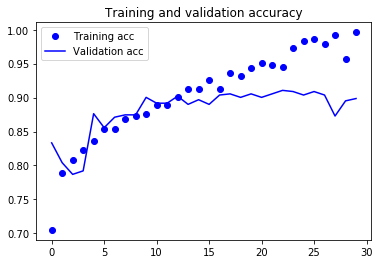

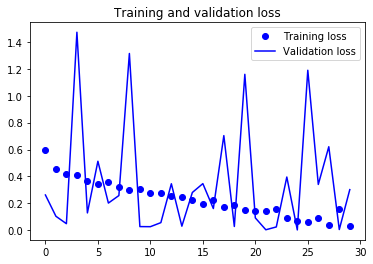

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
#model.save('hab_test_model.h5')

In [12]:
#augment the images
train_datagen = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=90, 
                                     brightness_range=[0.2,1.5], 
                                     horizontal_flip=True) 
                                                          

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(140, 140),
        batch_size=32)

validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        target_size=(140, 140), 
                                                        batch_size=32)

Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


In [13]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 139s 1s/step - loss: 0.4509 - acc: 0.8267 - val_loss: 0.0285 - val_acc: 0.9107
Epoch 2/30
100/100 [==============================] - 141s 1s/step - loss: 0.3931 - acc: 0.8393 - val_loss: 0.0542 - val_acc: 0.9210
Epoch 3/30
100/100 [==============================] - 152s 2s/step - loss: 0.3681 - acc: 0.8546 - val_loss: 0.2930 - val_acc: 0.9055
Epoch 4/30
100/100 [==============================] - 117s 1s/step - loss: 0.3271 - acc: 0.8691 - val_loss: 0.1446 - val_acc: 0.9278
Epoch 5/30
100/100 [==============================] - 110s 1s/step - loss: 0.3159 - acc: 0.8668 - val_loss: 0.1432 - val_acc: 0.9261
Epoch 6/30
100/100 [==============================] - 121s 1s/step - loss: 0.3031 - acc: 0.8740 - val_loss: 0.1931 - val_acc: 0.9261
Epoch 7/30
100/100 [==============================] - 130s 1s/step - loss: 0.3090 - acc: 0.8808 - val_loss: 0.0420 - val_acc: 0.9261
Epoch 8/30
100/100 [==============================] - 138s 1s/step - 

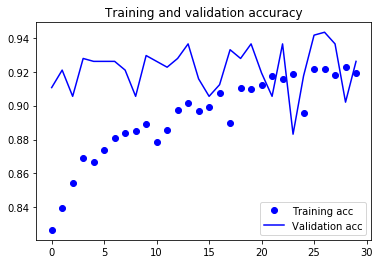

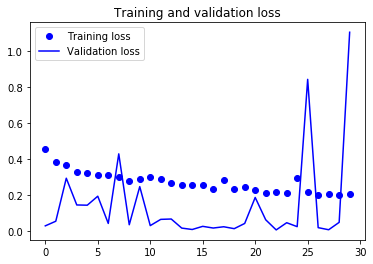

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
# final evaluation
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(140, 140), 
                                                  batch_size=20)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 288 images belonging to 2 classes.
test acc: 0.8252074718475342


In [ ]:
# manual predict 
# predict(x, batch_size=None, verbose=0, steps=None, 
#         callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

# prediction = model.predict(np.array(tk.texts_to_sequences(text)))
# print(prediction)

## TO DO

- check labels for classes 
- can a human label them easily?
- waht are the standards and accuracy for satellite traininng of models?
- for whom? 
- find image standard and demo with that image 

# Model improvements 

- manually crop images, increase saturation or contrast 
- fix scale? some images are quished, increase size 
- inception, resnet
- add more layers 

# Results

# Conclusions